In [7]:
!pip install statsmodels
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta


In [11]:
data = pd.read_csv('parkingLot.csv')
data['timestamp']=pd.to_datetime(data['timestamp'])
entry_data = data[data['camera_id'] == 1]
exit_data = data[data['camera_id'] == 2]
merged_data = pd.merge(entry_data, exit_data, on='vehicle_no', suffixes=('_entry', '_exit'))
merged_data['time_spent'] = (merged_data['timestamp_exit'] - merged_data['timestamp_entry']).dt.total_seconds() / 60
merged_data = merged_data[merged_data['time_spent'] > 0]
merged_data['date'] = merged_data['timestamp_entry'].dt.date
daily_avg_time = merged_data.groupby('date')['time_spent'].mean()
daily_avg_time = daily_avg_time.reset_index()
daily_avg_time['date'] = pd.to_datetime(daily_avg_time['date'])
daily_avg_time.set_index('date', inplace=True)
daily_avg_time['time_spent'] = daily_avg_time['time_spent'].interpolate(method='time')
daily_avg_time.index = pd.date_range(start=daily_avg_time.index[0], end=daily_avg_time.index[-1], freq='D')


In [12]:
train = daily_avg_time.iloc[:-7]
test = daily_avg_time.iloc[-7:]
arima_model = ARIMA(train['time_spent'], order=(5, 1, 0)).fit()
arima_forecast = arima_model.forecast(steps=7)
mase_arima = mean_absolute_error(test['time_spent'], arima_forecast) / mean_absolute_error(train['time_spent'], [train['time_spent'].mean()] * len(train))
mape_arima = np.mean(np.abs((test['time_spent'] - arima_forecast) / test['time_spent'])) * 100
ets_model = ExponentialSmoothing(train['time_spent'], seasonal='add', seasonal_periods=7).fit()
ets_forecast = ets_model.forecast(steps=7)
mase_ets = mean_absolute_error(test['time_spent'], ets_forecast) / mean_absolute_error(train['time_spent'], [train['time_spent'].mean()] * len(train))
mape_ets = np.mean(np.abs((test['time_spent'] - ets_forecast) / test['time_spent'])) * 100


/mnt/c/Users/D/Downloads/repo/git/Data-Davinci/venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ARIMA - MASE: 0.0882156551681503, MAPE: 94.39604514826208
ETS - MASE: 0.10913463408387818, MAPE: 130.0738797332031


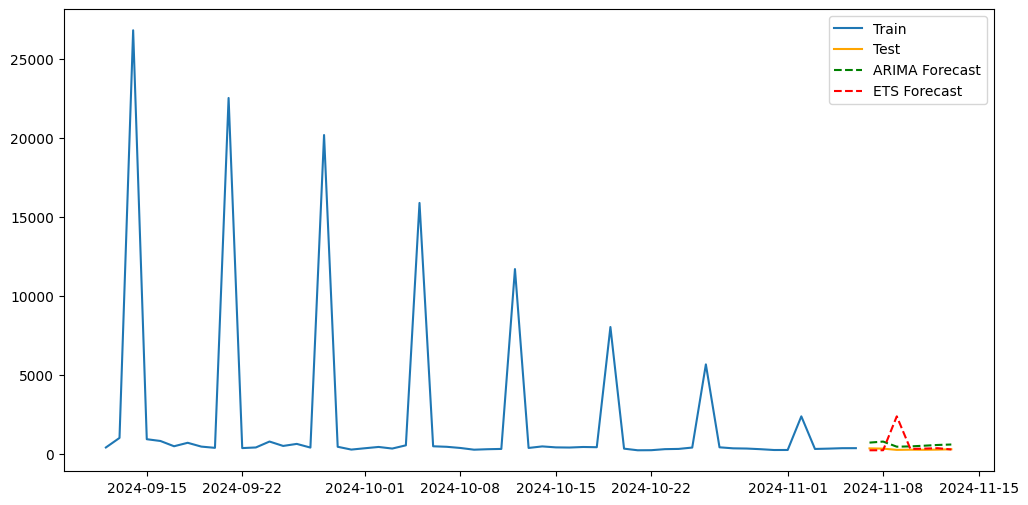

In [13]:
print(f"ARIMA - MASE: {mase_arima}, MAPE: {mape_arima}")
print(f"ETS - MASE: {mase_ets}, MAPE: {mape_ets}")
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['time_spent'], label='Train')
plt.plot(test.index, test['time_spent'], label='Test', color='orange')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='green')
plt.plot(test.index, ets_forecast, label='ETS Forecast', linestyle='--', color='red')
plt.legend()
plt.show()
